# Introduction to Numerical ODE Solutions
*Originally developed based on material here: http://phys.csuchico.edu/ayars/312 *


In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Euler method

### Definition of the Euler method

In [3]:
def euler(derivs, yo, times):
    dims = len(yo)   # number of dimensions
    N = len(times)  # number of time slices
    y = np.zeros([N, dims])  # array of solutions

    # initial condition
    y[0] = yo

    # calculate the rest
    for j in range(1,N):
        t = times[j]
        dt = t-times[j-1]
        y[j] = y[j-1] + derivs(t-dt, y[j-1])*dt
        
    # return the answer
    return y


### Example

Define a differential equation: fall with air drag
$$ a = \frac{dv}{dt} = g - cv^2 $$
$$ c = \frac{1/2 \rho A C_d}{m} $$

Where
- $ \rho $ - density of the fluid,
- $ C_d $ - drag coefficient,
- $ A $ - cross-sectional area, and
- $m$ - mass

In [4]:
def drag(time, state):
    global g,c
    v = state[0]
    return g - c*v*v  

Integration example

Terminal velocity = 7.5 m/s
Equivalent to falling from 2.9 m height without air resistance


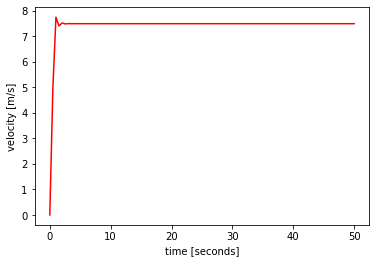

In [5]:
initial_state = np.array([0.0])
g = 9.81

# Human falling in air
rho = 1.225 # kg/m^3
Cd = 1
A = 20 # m^2 (parachute)
mass = 70 # kg
c = 0.5*A*rho*Cd/mass

times = np.linspace(0,50,100)      # 0.5 sec steps. check how results depend on step size
velocity = euler(drag,initial_state,times)

plt.plot(times,velocity,'r-')
plt.xlabel('time [seconds]')
plt.ylabel('velocity [m/s]')

vTerm = velocity[-1][0]
print('Terminal velocity = {0:.1f} m/s'.format(vTerm))
print('Equivalent to falling from {0:.1f} m height without air resistance'.format(0.5*vTerm**2/g))

### Example 2 : Simple Harmonic Oscillator

Define a differential equation: simple harmonic motion


In [6]:
def SHO(time, state):
    global omega
    g0 = state[1]
    g1 = -omega*omega*state[0]
    return np.array([g0,g1])


Set up the initial conditions and integration times

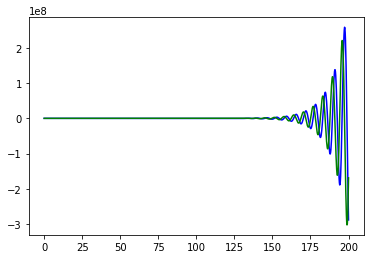

In [7]:
initial_state = np.array([1,0])    # Here the initial condition is x!=0, v=0.
omega = 1
wanted_times = np.linspace(0, 200, 1000)
answer = euler(SHO, initial_state, wanted_times)

# Plot the results
x = answer[:,0]
v = answer[:,1]
plt.plot(wanted_times, x, 'b-')
plt.plot(wanted_times, v, 'g-')
plt.show()


## Part 2: Euler-Cromer (improved Euler)

In [8]:
def eulerC(derivs, yo, times):
    elements = len(yo)
    N = len(times)
    y = np.zeros([N, elements])

    # initial condition
    y[0] = yo

    # calculate the rest
    for j in range(1,N):
        t = times[j]
        dt = t-times[j-1]
        y[j] = y[j-1] + derivs(t, y[j-1])*dt
        
        
    # improve the calculation by computing the velocity at the *next* step    
    for j in range(1,N):
        t = times[j]
        dt = t-times[j-1]
        y[j,0] = y[j-1,0] + derivs(t, y[j-1])[0]*dt    
        y[j,1] = y[j-1,1] + derivs(t, y[j])[1]*dt    
    # return the answer
    return y


### Simple Harmonic Oscillator (Again)

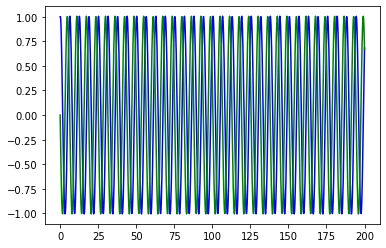

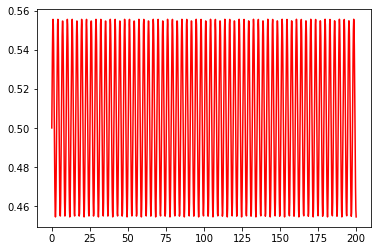

In [9]:
answer = eulerC(SHO, initial_state, wanted_times)

# Plot the results
x = answer[:,0]
v = answer[:,1]
plt.plot(wanted_times, x, 'b-')
plt.plot(wanted_times, v, 'g-')
plt.show()

# plot energy vs time
m = 1
k = omega*omega*m
energy = 0.5*(k*x**2 + m*v**2)
plt.plot(wanted_times,energy,'r-')


## Part 3: Runge-Kutta method

Now let's implement a 2nd-order Runge Kutta (RK).
This function moves the value of ’y’ forward by a single step of size ’dt’, 
using a second−order Runge−Kutta algorithm. This particular algorithm is equivalent to 
finding the average of the slope at time t and at time
( t+dt ) , and using that average slope to find value of y.

In [10]:
def rk2(y, time, dt, derivs): 
    k1 = dt*derivs(time, y)
    k2 = dt*derivs(time+dt, y+k1) 
    y_next = y+0.5*(k1+k2)
    return y_next

### Examples

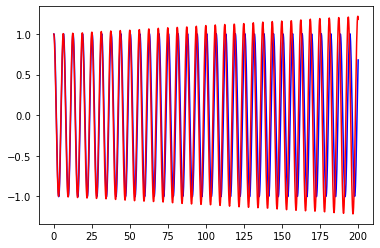

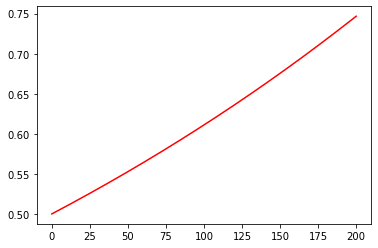

In [11]:
initial_state = np.array([1,0])    # Here the initial condition is x!=0, v=0.
omega = 1
N = 1000  # number of steps
tau = 200 # max time
dt = tau/float(N-1)  # step size
wanted_times = np.linspace(0, tau, N)

answerE  = euler(SHO, initial_state, wanted_times)

answerEK  = eulerC(SHO, initial_state, wanted_times)

answerRK = np.zeros([N,2])
answerRK[0,:] = initial_state
for j in range (N-1):
    answerRK[j+1] = rk2(answerRK[j], 0, dt , SHO)

# Plot the results
x = answerEK[:,0]
xE = answerE[:,0]
vE = answerE[:,1]
xRK = answerRK[:,0]
vRK = answerRK[:,1]
plt.plot(wanted_times, x, 'b-')   # Euler-Cromer
#plt.plot(wanted_times, xE, 'g-')  # Euler
plt.plot(wanted_times, xRK, 'r-') # RK2
plt.show()

# plot energy vs time
m = 1
k = omega*omega*m
energy = 0.5*(k*xRK**2 + m*vRK**2)
plt.plot(wanted_times,energy,'r-')

## SciPy library 

SciPy offers an interface to multiple integration routines, incuding RK23 , RK45, and LSODA routine from ODEPACK Fortran library (adaptive, high-performance multi-step integration) -- see <a href="https://docs.scipy.org/doc/scipy/reference/integrate.html">scipy.integrate</a>. In particular, notice parameter ``rtol``

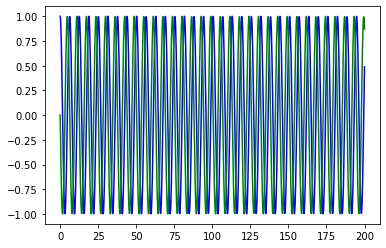

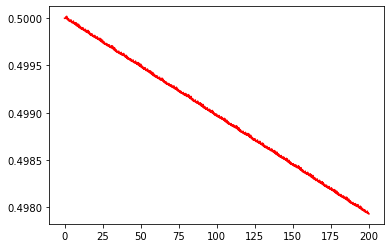

In [17]:
from scipy.integrate import solve_ivp

answer  = solve_ivp(SHO, y0=initial_state, method='RK45', 
                    t_span=(wanted_times[0],wanted_times[-1]), 
                    t_eval=wanted_times, rtol=1e-4)
#print(answer)
x = answer.y[0,:]
v = answer.y[1,:]
plt.plot(wanted_times, x, 'b-')
plt.plot(wanted_times, v, 'g-')
plt.show()

# plot energy vs time
m = 1
k = omega*omega*m
energy = 0.5*(k*x**2 + m*v**2)
plt.plot(wanted_times,energy,'r-')

#### Older interface

Discouraged in new implementation of SciPy, but very accurate and fast !

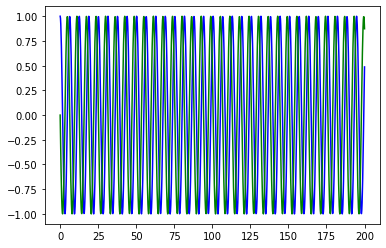

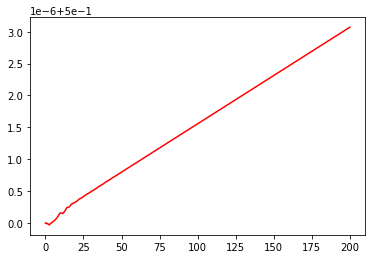

In [18]:
from scipy.integrate import odeint

answer  = odeint(SHO, initial_state, wanted_times,tfirst=True)
x = answer[:,0]
v = answer[:,1]
plt.plot(wanted_times, x, 'b-')
plt.plot(wanted_times, v, 'g-')
plt.show()

# plot energy vs time
m = 1
k = omega*omega*m
energy = 0.5*(k*x**2 + m*v**2)
plt.plot(wanted_times,energy,'r-')